
Step 3 - Model Evaluation Summary:
                 Model  Accuracy  Precision (0)  Recall (0)  F1 (0)  \
0  Logistic Regression    0.7342         0.8890      0.7289  0.8011   
1        Random Forest    0.7235         0.8936      0.7076  0.7898   
2              XGBoost    0.7463         0.8894      0.7473  0.8122   
3                  ANN    0.7548         0.8764      0.7754  0.8228   

   Precision (1)  Recall (1)  F1 (1)  ROC AUC  
0         0.5000      0.7487  0.5996   0.8087  
1         0.4873      0.7674  0.5961   0.8050  
2         0.5158      0.7433  0.6090   0.8174  
3         0.5294      0.6979  0.6021   0.8152  


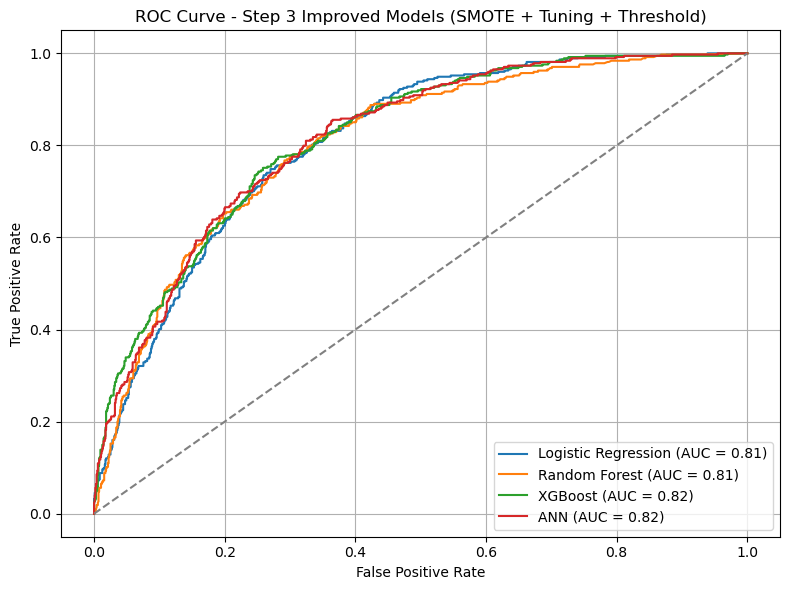

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    precision_recall_curve, roc_curve
)
from imblearn.over_sampling import SMOTE
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# [1] Load and preprocess data
df = pd.read_csv("../data/Telecom Customers Churn.csv")
df.drop("customerID", axis=1, inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# Encode categorical variables
categorical_cols = df.select_dtypes(include="object").columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop("Churn", axis=1)
y = df["Churn"]

# [2] Train-test split BEFORE scaling or SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# [3] Apply SMOTE before scaling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# [4] Scale AFTER SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# [5] Compute scale_pos_weight for XGBoost
scale_pos_weight = (y_train_smote == 0).sum() / (y_train_smote == 1).sum()

# [6] Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=2000, class_weight='balanced')
logreg_params = {'C': np.linspace(0.1, 2.0, 10), 'penalty': ['l2']}
logreg_cv = RandomizedSearchCV(logreg, logreg_params, n_iter=5, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
logreg_cv.fit(X_train_scaled, y_train_smote)

# [7] Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}
rf_cv = RandomizedSearchCV(rf, rf_params, n_iter=5, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
rf_cv.fit(X_train_scaled, y_train_smote)

# [8] XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_cv = RandomizedSearchCV(xgb, xgb_params, n_iter=5, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
xgb_cv.fit(X_train_scaled, y_train_smote)

# [9] ANN
def create_ann_model(neurons=64, learning_rate=0.001, dropout_rate=0.3, hidden_layers=2):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    for _ in range(hidden_layers):
        model.add(Dense(neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['AUC'])
    return model

ann = KerasClassifier(model=create_ann_model, verbose=0)
ann_params = {
    'model__neurons': [64, 128],
    'model__learning_rate': [0.0005, 0.001],
    'model__dropout_rate': [0.2, 0.3],
    'model__hidden_layers': [2, 3],
    'batch_size': [32, 64],
    'epochs': [40, 60]
}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
sample_weights = np.where(y_train_smote == 1, 2.0, 1.0)
ann_cv = RandomizedSearchCV(estimator=ann, param_distributions=ann_params, n_iter=10,
                            scoring='roc_auc', cv=5, random_state=42, verbose=0, n_jobs=1)
ann_cv.fit(X_train_scaled, y_train_smote, sample_weight=sample_weights,
           callbacks=[early_stopping], validation_split=0.1)
best_ann = ann_cv.best_estimator_

# [10] Evaluation with threshold tuning
def evaluate_model(name, model):
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[max(0, best_idx - 1)]
    y_pred = (y_proba >= best_thresh).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    return {
        "name": name,
        "accuracy": round(accuracy_score(y_test, y_pred), 4),
        "precision_0": round(report["0"]["precision"], 4),
        "recall_0": round(report["0"]["recall"], 4),
        "f1_0": round(report["0"]["f1-score"], 4),
        "precision_1": round(report["1"]["precision"], 4),
        "recall_1": round(report["1"]["recall"], 4),
        "f1_1": round(report["1"]["f1-score"], 4),
        "roc_auc": round(roc_auc_score(y_test, y_proba), 4),
        "fpr": fpr,
        "tpr": tpr
    }

models = {
    "Logistic Regression": logreg_cv,
    "Random Forest": rf_cv,
    "XGBoost": xgb_cv,
    "ANN": best_ann
}
results = [evaluate_model(name, model) for name, model in models.items()]

# [11] Display results
df_results = pd.DataFrame([{
    "Model": r["name"],
    "Accuracy": r["accuracy"],
    "Precision (0)": r["precision_0"],
    "Recall (0)": r["recall_0"],
    "F1 (0)": r["f1_0"],
    "Precision (1)": r["precision_1"],
    "Recall (1)": r["recall_1"],
    "F1 (1)": r["f1_1"],
    "ROC AUC": r["roc_auc"]
} for r in results])
print("\nStep 3 - Model Evaluation Summary:")
print(df_results)

# [12] ROC Curve
plt.figure(figsize=(8, 6))
for r in results:
    plt.plot(r["fpr"], r["tpr"], label=f"{r['name']} (AUC = {r['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Step 3 Improved Models (SMOTE + Tuning + Threshold)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
